# <center>Лекція 6. Побудова й відбір ознак</center>

<a class="anchor" id="6"></a>

## Зміст

- [6.1. Виявлення ознак (Feature extraction)](#6.1)
    + [6.1.1. Тексти](#6.1.1)
    + [6.1.2. Зображення](#6.1.2)
    + [6.1.3. Геодані](#6.1.3)
    + [6.1.4. Дата та час](#6.1.4)
    + [6.1.5. Часові ряди, веб та інше](#6.1.5)   
- [6.2. Перетворення ознак (Feature transformations)](#6.2)
    + [6.2.1. Нормалізація та зміна розподілу](#6.2.1)
    + [6.2.2. Взаємодія (Interactions)](#6.2.2)
    + [6.2.3. Заповнення пропусків](#6.2.3) 
- [6.3. Відбір ознак (Feature selection)](#6.3)
    + [6.3.1. Статистичні підходи](#6.3.1)
    + [6.3.2. Відбір із використанням моделей](#6.3.2)
    + [6.3.3. Перебір](#6.3.2)
- [6.4. Основні метрики якості класифікації](#6.4)
    + [6.4.1. Матриця невідповідностей](#6.4.1)
    + [6.4.2. Характеристики бінарного класифікатора](#6.4.2)
    + [6.4.3. ROC-крива та AUC](#6.4.3)
    + [6.4.4. Дисбаланс класів](#6.4.4)
    + [6.4.5. Приклади застосувань метрик класифікації](#6.4.5)
    + [6.4.6. Багатокласова класифікація](#6.4.6)
    + [6.4.7. One vs. All](#6.4.7)
- [6.5. Корисні посилання](#6.5)

В рамках курсу ми вже познайомилися з кількома ключовими алгоритмами машинного навчання (МН) для оброблення статистичних даних. Проте перед тим як переходити до більш складних алгоритмів та статистичних підходів, скажимо кілька слів про підготовку даних для навчання моделі. Відомий принцип garbage in - garbage out є на 100% застосовуваним щодо будь-якого завдання МН. Будь-який досвідчений інженер може згадати приклади з практики, коли проста модель, навчена на якісно підготовлених даних, показала себе краще хитромудрого ансамблю, побудованого на недостатньо чистих даних.

В поточній лекції розглянемо три схожих завдання в задачі підготовки та оброблення ознак:
* **feature extraction** і **feature engineering**, з англ. мови "виявлення ознак" – це перетворення даних, специфічних для предметної області, у вектори, що є зрозумілими для моделі;
* **feature transformation**, з англ. мови "перетворення ознак" – це трансформація даних для підвищення точності алгоритму;
* **feature selection** з англ. мови "відбір ознак" – це відбір найбільш значущих ознак або відсікання непотрібних ознак.

У прикладах до лекції будемо використовувати набір даних компанії Renthop із Kaggle-змагання [Two Sigma Connect: Rental Listing Inquiries Kaggle competition](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries).

У цьому завданні потрібно передбачити популярність оголошення щодо оренди нерухомості, тобто розв'язати задачу класифікації з трьома класами `['low', 'medium', 'high']`. Для оцінки розв'язку використовується метрика log loss (чим менше – тим краще). 

Для інсталювання необхідного пакету в середовищі Google Colab потрібно ввести першій комірці:

```python
!pip install user-agents
!pip install mlxtend
```

Для інсталювання необхідного пакету в середовищі Anaconda потрібно в терміналі ввести наступні команди:

```python
conda install -c conda-forge mlxtend
conda install -c conda-forge user-agents
```

In [1]:
from __future__ import division, print_function
# Відключимо попередження Anaconda
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np
import pandas as pd

In [2]:
# Відразу завантажимо набір даних з Renthop
with open('train.json', 'r') as raw_data:
    data = json.load(raw_data)
    df = pd.DataFrame(data)

%matplotlib inline
from matplotlib import pyplot as plt

# Задамо графіки у форматі .svg, щоби вони мали кращу чіткість
# %config InlineBackend.figure_format = 'svg' 

# Підвищимо розмір графіків за замовчуванням
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 7, 5

<a class="anchor" id="6.1"></a>

## <span style="color:blue; font-size:1.2em;">6.1. Виявлення ознак (Feature extraction)</span>

[Повернутися до змісту](#6)

На практиці вкрай рідко дані отримують у вигляді готових матриць. Тому будь-яка задачі розпочинається з виявлення ознак. Іноді набір даних для розв'язування задачі є підготовленим заздалегідь. В такому разі достатньо прочитати `.csv` файл і конвертувати його в `numpy.array`. Проте це, на жаль, такі випадки є вкрай винятковими, коли хтось інший поторбувався за підготовку даних. Тому щоби навчитися готувати дані для моделювання, розглянемо найбільш популярні типи даних, з яких зазвичай вилучають ознаки.

<a class="anchor" id="6.1.1"></a>

### <span style="color:blue; font-size:1.2em;"> 6.1.1. Текстові дані</span>

[Повернутися до змісту](#6)

Текст – найбільш очевидний приклад даних у вільному форматі. Методів роботи з текстом дуже багато, в одній лекції вони не помістяться. Тим не менш, оглядово розглянемо найпопулярніші.

Перед тим, як працювати з текстом, його необхідно [токенізувати](https://neptune.ai/blog/tokenization-in-nlp). Токенізація передбачає розбиття тексту на так звані токени – у найпростішому випадку це слова. Проте надто спрощуючи це поняття ми можемо втратити частину сенсу, наприклад, назва містечка "Велика Рогань" це не два токена, а один. Втім заклик "кради-вбивай!" даремно розділяти на два токени, тут два слова позначають один сенс. Існують готові токенайзери, які враховують особливості мови, але й вони можуть помилятися, особливо якщо ви працюєте зі специфічними текстами (професійна лексика, жаргонізми, друкарські помилки тощо).

Після токенізації зазвичай потрібно проводити [нормалізацію](https://en.wikipedia.org/wiki/Normalization_(statistics). Тут мова йде за [стемінг](https://en.wikipedia.org/wiki/Stemming) та/або [лематизацію](https://en.wikipedia.org/wiki/Lemmatisation) – це схожі процеси, що використовуються для оброблення словоформ. Про різницю між ними можна прочитати [тут](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html).

Отже, після перетворення текстового документа на послідовність слів, можна починати перетворювати їх на вектора. Найпростіший підхід називається [Bag of Words](https://www.freecodecamp.org/news/an-introduction-to-bag-of-words-and-how-to-code-it-in-python-for-nlp-282e87a9da04/): створюємо вектор довжиною у словник, для кожного слова обраховуємо кількість входжень у текст та підставляємо це число на відповідну позицію у векторі. Ідея підходу добре ілюструється таким зображенням:

<img src="https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/6_1_bag-of-words.png" align="center" width=80% height=80%>

Програмний код цього механізму виглядає навіть простіше, ніж звучить на словах:

In [3]:
from functools import reduce 
import numpy as np

texts = [['i', 'have', 'a', 'cat'], 
        ['he', 'have', 'a', 'dog'], 
        ['he', 'and', 'i', 'have', 'a', 'cat', 'and', 'a', 'dog']]

dictionary = list(enumerate(set(list(reduce(lambda x, y: x + y, texts)))))

def vectorize(text): 
    vector = np.zeros(len(dictionary)) 
    for i, word in dictionary: 
        num = 0 
        for w in text: 
            if w == word: 
                num += 1 
        if num: 
            vector[i] = num 
    return vector

for t in texts: 
    print(vectorize(t))

[1. 1. 1. 0. 0. 0. 1.]
[1. 1. 0. 1. 0. 1. 0.]
[1. 2. 1. 1. 2. 1. 1.]


На практиці потрібно подбати про стоп-слова, максимальний розмір словника та ефективну структуру даних (зазвичай текстові дані перетворюють на розріджені вектори).

Водночас використання алгоритмів на кшталт Вag of Words призводить до втрати порядку слів у тексті, тобто, тексти "i have no cows" та "no, i have cows" будуть ідентичними після векторизації, хоча і протилежними семантично. Щоб уникнути цієї проблеми, можна зробити крок назад і змінити підхід до токенізації: наприклад використовувати [N-грами](https://uk.wikipedia.org/wiki/N-%D0%B3%D1%80%D0%B0%D0%BC%D0%B0) (*комбінації* з N послідовних термінів).

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(1,1))
vect.fit_transform(['no i have cows', 'i have no cows']).toarray()

array([[1, 1, 1],
       [1, 1, 1]], dtype=int64)

In [5]:
vect.vocabulary_ 

{'no': 2, 'have': 1, 'cows': 0}

In [6]:
vect = CountVectorizer(ngram_range=(1,2))
vect.fit_transform(['no i have cows', 'i have no cows']).toarray()

array([[1, 1, 1, 0, 1, 0, 1],
       [1, 1, 0, 1, 1, 1, 0]], dtype=int64)

In [7]:
vect.vocabulary_

{'no': 4,
 'have': 1,
 'cows': 0,
 'no have': 6,
 'have cows': 2,
 'have no': 3,
 'no cows': 5}

Також варто зазначити, що необов'язково оперувати саме словами: у деяких випадках можна генерувати N-грами з літер. Наприклад, такий алгоритм врахує схожість споріднених слів або друкарських помилок.

In [8]:
from scipy.spatial.distance import euclidean
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(3,3), analyzer='char_wb')

n1, n2, n3, n4 = vect.fit_transform(['andersen', 'petersen', 'petrov', 'smith']).toarray()

euclidean(n1, n2), euclidean(n2, n3), euclidean(n3, n4)

(2.8284271247461903, 3.1622776601683795, 3.3166247903554)

Розвиток ідеї Bag of Words: слова, які рідко зустрічаються в корпусі (у всіх документах цього набору даних), але присутні в цьому конкретному документі, можуть виявитися більш важливими. В такому разі варто підвищити вагу більш вузькотематичних слів, щоб відокремити їх від загальнотематичних. Цей підхід називається [TF-IDF](https://uk.wikipedia.org/wiki/TF-IDF). Варіант TF-IDF за замовчуванням виглядає так:


$$ \large idf(t,D) = \log\frac{\mid D\mid}{df(d,t)+1}, $$

$$ \large tfidf(t,d,D) = tf(t,d) \times idf(t,D). $$

Аналоги підходу Bag of words можуть зустрічатися й поза текстовими задачами: наприклад, bag of sites в [Catch Me If You Can competition](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking), [Bag of apps](https://www.kaggle.com/xiaoml/talkingdata-mobile-user-demographics/bag-of-app-id-python-2-27392), [Bag of events](https://www.gelbukh.com/ijcla/2015-2/IJCLA-2015-2.pdf#page=11) тощо.

Використання таких алгоритмів дає змогу отримати цілком робоче рішення простої проблеми, так званий baseline (з англ. "початкове рішення"). Проте, для тих дослідників/інженерів, які полюбляють щось більш сучасне, на ринку доступні нові підходи. Найпопулярніший метод нової хвилі – [Word2Vec](https://towardsdatascience.com/word2vec-explained-49c52b4ccb71), але є й альтернативи ([Wang2Vec](https://github.com/wlin12/wang2vec), [Glove](https://medium.com/analytics-vidhya/word-vectorization-using-glove-76919685ee0b), [fastText](https://fasttext.cc/)).

Word2Vec є частинним випадком алгоритмів Word Embedding. Використання Word2Vec та подібних підходів дає змогу не лише векторизувати слова у просторі великої розмірності (зазвичай кілька сотень), а й порівнювати їхню семантичну близькість. Класичний приклад операцій над векторизованими поданнями: ***king – man + woman = queen***.

<img src="https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/6_2_king-man%2Bwoman.gif" align="center" width=50% height=50%>

Варто розуміти, що ця модель не володіє розумінням слів, а лише намагається розмістити вектори так, щоб слова, які вживаються в загальному контексті, розміщувалися недалеко один від одного. Якщо цього не враховувати, можуть виникати багато курйозів: наприклад, знайти протилежність Гітлеру через множення відповідного вектора на -1. 

Такі моделі мають навчатися на великих наборах даних, щоб координати векторів дійсно відображали семантику слів. Для розв'язування власних задач можна завантажити напереднавчену модель, наприклад, [тут](https://github.com/3Top/word2vec-api#where-to-get-a-pretrained-models).

Схожі методи використовуються також в інших областях (наприклад, у біоінформатиці). З несподіваних застосувань – [food2vec](https://jaan.io/food2vec-augmented-cooking-machine-intelligence/). Ви також можете свої ідеї; концепція досить універсальна.

<a class="anchor" id="6.1.2"></a>

### <span style="color:blue; font-size:1.2em;">6.1.2. Зображення</span>

[Повернутися до змісту](#6)

Робота із зображеннями стає все простішою з року в рік. Перш за все, тому що часто можна взагалі не думати, а просто використати одну з популярних нейронних мереж. Втім, тут також не без проблем: для доволі складних задач із обробленням зображень потрібно багато чого знати.

У часи, коли [GPU](https://en.wikipedia.org/wiki/Graphics_processing_unit) були слабшими, а "ренесанс нейромереж" ще не трапився, генерація візуальних ознак із зображень була окремою досить складною підгалуззю. Для роботи із зображеннями потрібно було працювати на низькому рівні, визначаючи, наприклад, кути, границі об'єктів тощо. Досвідчені фахівці у галузі комп'ютерного зору могли б провести багато паралелей між традиційними (старішими) підходами та сучасним нейромережевим моделюванням: зокрема, згорткові шари в сучасних мережах дуже схожі на [каскади Хаара](https://en.wikipedia.org/wiki/Haar-like_feature). Залишимо кілька посилань на популярні в минулому бібліотеки [skimage](http://scikit-image.org/docs/stable/api/skimage.feature.html) та [SimpleCV](http://simplecv.readthedocs.io/en/latest/SimpleCV.Features.html) і перейдемо відразу до теперішнього часу.

Часто для задач із обробленням зображень використовується якась згорткова мережа. У такому разі не треба вигадувати свою архітектуру і не навчати мережу з нуля, а взяти напереднавчену "state of the art" нейронну мережу, ваги якої можна завантажити з відкритих джерел. Щоб адаптувати її під свою задачу, дослідники практикують так званий "fine tuning": останні повнозв'язні шари мережі "відриваються", замість них додаються нові, підібрані під конкретну задачу, і мережа донавчається на нових даних. Проте якщо ви векторизуєте зображення для якихось своїх цілей (наприклад, використовуєте якийсь немережевий класифікатор) – просто відірвіть останні шари та використовуйте вихідну інформацію попередніх шарів:

In [9]:
# За бажання цей код можна роздокоментувати та подивитися
# на результат застосування бібліотеки PyTorch

# import torch
# from torchvision import models, transforms
# from PIL import Image
# import numpy as np
# from scipy.misc import face

# # Визначення трансформацій зображення
# transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# # Завантаження попередньо підготовленої моделі ResNet50
# resnet = models.resnet50(pretrained=True)
# resnet.eval()  # Set the model to evaluation mode

# # Завантаження та попереднє оброблення зображення
# img = Image.fromarray(face())  # Convert numpy array to PIL Image
# img = img.convert('RGB')  # Convert to RGB if necessary
# img = transform(img)

# # Додавання додаткового виміру
# img = img.unsqueeze(0)

# # Прогноз
# with torch.no_grad():
#     features = resnet(img)


<figure>
<img src="https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/6_3_neural-net.png" alt="Trulli" style="width:100%">
<figcaption align = "center"><i>Згорткова нейронна мережа - типовий приклад архітектури нейронної мережі, що містить у собі як блоки для виявлення ознак, так і блоки для класифікації отриманого вектора ознак</i></figcaption>
</figure>

Проте не варто зациклюватися лише на нейромережевих методах. Деякі ознаки, згенеровані руками, можуть виявитися корисними і тепер: наприклад, прогнозуючи популярність оголошень про оренду квартири, можна припустити, що світлі квартири більше привертають увагу, і оформити ознаку "середнє значення пікселя". Надихнутися прикладами можна у документації відповідних [бібліотек](http://pillow.readthedocs.io/en/3.1.x/reference/ImageStat.html).

Якщо на зображенні очікується блоки з текстом, то його можна прочитати й без розгортання складних нейромереж власними руками: наприклад, за допомогою [pytesseract](https://github.com/madmaze/pytesseract).

```python
import pytesseract
from PIL import Image
import requests
from io import BytesIO

# Випадкове зображення з інтернет-пошуку
img = 'http://ohscurrent.org/wp-content/uploads/2015/09/domus-01-google.jpg'

img = requests.get(img)
img = Image.open(BytesIO(img.content))
text = pytesseract.image_to_string(img)

text

Out: 'Google'
```

Варто пам'ятати, що `pytesseract` – не панацея:

```python
# Цього разу беремо зображення з Renthop
img = requests.get('https://photos.renthop.com/2/8393298_6acaf11f030217d05f3a5604b9a2f70f.jpg')
img = Image.open(BytesIO(img.content))
pytesseract.image_to_string(img)

Out: 'Cunveztible to 4}»'
```

Ще один випадок, коли нейронні мережі не допоможуть – виявлення ознак з метаінфорації. В EXIF може зберігатися багато корисного: виробник і модель камери, дозвіл, використання спалаху, геокоординати зйомки, використане для оброблення програмне забезпечення та багато іншого.

<a class="anchor" id="6.1.3"></a>

### <span style="color:blue; font-size:1.2em;"> 6.1.3. Геодані</span>

[Повернутися до змісту](#6)

Географічні дані трапляються в реальних задачах не так часто, як вище вказані, проте корисно освоїти основні методи роботи з ними, тим більше, що в цій галузі також достатньо готових рішень.

Геодані найчастіше подані у вигляді адрес або пар "широта + довгота", тобто, у вигляді точок на карті. З огляду на умову задачі, можуть знадобитися дві протилежні операції: геокодування (відновлення точки з адреси) та зворотне геокодування (навпаки). Обидві операції здійсненні за допомогою зовнішніх API, таких як Google Maps або OpenStreetMap. Різні геокодери мають власні характеристики, якість змінюється від регіону до регіону. На сьогодні наявні універсальні бібліотеки, наприклад, [geopy](https://github.com/geopy/geopy), які є так званою обгорткою над багатьма зовнішніми сервісами.

Якщо даних багато, то зовнішні API можуть спричиняти різні обмеження та проблеми. А для отримання інформації за HTTP далеко не завжди є оптимальнм рішенням за швидкостю. Тому варто пам’ятати про можливість використання локальної версії OpenStreetMap.

Якщо даних мало, часу достатньо, але немає бажання вилучати складні ознаки, то можна не "гратися" з OpenStreetMap і використати `reverse_geocoder`:

```python
import reverse_geocoder as revgc

revgc.search((df.latitude, df.longitude))
Loading formatted geocoded file... 

Out: [OrderedDict([('lat', '40.74482'), 
                   ('lon', '-73.94875'), 
                   ('name', 'Long Island City'), 
                   ('admin1', 'New York'), 
                   ('admin2', 'Queens County'), 
                   ('cc', 'US')])]
```

Працюючи з геокодингом, ми не повинні забувати про те, що адреси можуть містити помилки. Тому потрібно виконувати очистку даних. У координатах друкарських помилок зазвичай менше, але і з ними не все добре: GPS за природою даних може "шуміти", а в деяких місцях (тунелі, квартали хмарочосів njoj) – досить сильно. Якщо джерело даних – мобільний пристрій, то варто врахувати, що в деяких випадках геолокація визначається не за GPS, а за мережами Wi-Fi в окрузі, що веде до "дірок" у просторі та "телепортації": поміж набору точок, що описують подорож Манхеттеном може раптово опинитися одна з Чикаго.

>Гіпотеза про телепортацію.
Крапка зазвичай перебуває не в чистому полі, а поміж інфраструктури – тут можна дати волю фантазії та почати вигадувати ознаки, застосовуючи життєвий досвід та знання щодо предметної області. Близькість точки до метро, поверховість забудови, відстань до найближчого магазину, кількість банкоматів у радіусі – в рамках одного завдання можна вигадувати десятки ознак та видобувати їх із різних зовнішніх джерел. Для завдань поза міською інфраструктурою можуть стати в нагоді ознаки з більш специфічних джерел: наприклад, висота над рівнем моря.

Якщо дві або більше точок взаємопов'язані, то можливо, варто вилучати ознаки маршруту між ними. Тут знадобляться дистанції (варто дивитися і на great circle distance, і на "чесну" відстань, обраховану за дорожнім графом), кількість поворотів разом із співвідношенням лівих та правих, кількість світлофорів, розв'язок, мостів тощо. Наприклад, непогано може спрацювати ознака під назвою "складність дороги" – це відстань, що обрахована за графом і поділена на GCD.

<a class="anchor" id="6.1.4"></a>

### <span style="color:blue; font-size:1.2em;">6.1.4. Дата і час </span>

[Повернутися до змісту](#6)

Здавалося б, робота з датою і часом має бути стандартизована через поширеність відповідних ознак, але тут також не без проблем.

Почнемо з днів тижня – їх легко перетворити на 7 "dummy" змінних за допомогою "one-hot" кодування. Крім цього, корисно виділити окрему ознаку`is_weekend`.

```python
df['dow'] = df['created'].apply(lambda x: x.date().weekday())
df['is_weekend'] = df['created'].apply(lambda x: 1 if x.date().weekday() in (5, 6) else 0)
```

Деякі практичні задачі можуть потребувати додаткові календарні ознаки: наприклад, зняття готівки може бути прив'язане до дня видачі зарплат, а придбання проїзного – до початку місяця. Водночас, працюючи з часовими даними, треба мати під рукою календар із державними святами, аномальними погодними умовами та іншими важливими подіями.

Професійний несмішний гумор:

> Q: Що спільного між китайським новим роком, нью-йорським марафоном, гей-парадом та інавгурацією Трампа?

> A: Їх усіх потрібно внести до календаря потенційних аномалій.

А ось із годиною (хвилиною, днем місяця тощо) все не так і добре. Якщо використовувати годину як дійсну змінну, ми будемо суперечати природі даних: `22 < 23`, хоча `02.01 0:00:00 > 01.01 23:00:00`. Для деяких задач це може бути критичним. Якщо ж кодувати їх як категоріальні змінні, можна натворити купу ознак і втратити інформацію про близькість: різниця між 22 та 23 буде такою самою, як і між 22 та 7.

Існують і більш езотеричні підходи до таких даних. Наприклад, проєкція на коло з подальшим використанням двох координат.

In [10]:
def make_harmonic_features(value, period=24):
    value *= 2 * np.pi / period 
    return np.cos(value), np.sin(value)

Таке перетворення зберігає дистанцію між точками, що важливо для деяких алгоритмів, які ґрунтуються на відстані (kNN, SVM, k-means тощо)

In [11]:
from scipy.spatial import distance
euclidean(make_harmonic_features(23), make_harmonic_features(1)) 

0.5176380902050424

In [12]:
euclidean(make_harmonic_features(9), make_harmonic_features(11)) 

0.5176380902050414

In [13]:
euclidean(make_harmonic_features(9), make_harmonic_features(21))

2.0

Втім, різницю між такими способами кодування зазвичай можна вловити лише у третьому знаку після коми у метриці.

<a class="anchor" id="6.1.5"></a>

### <span style="color:blue; font-size:1.2em;">6.1.5. Часові ряди, веб та інше</span>

[Повернутися до змісту](#6)

Для роботи з ознаками часових рядів є чудова бібліотека [tsfresh](https://github.com/blue-yonder/tsfresh). Бібліотека призначена для автоматичної генерації ознак з часових рядів.

Якщо ви працюєте з вебом, у вас зазвичай є інформація про User Agent користувача. Це корисне джерело інформації. По-перше, звідти насамперед потрібно вилучити операційну систему. По-друге, зробити ознаку `is_mobile`. По-третє, подивитися на браузер.

In [14]:
# Установить pyyaml ua-parser user-agents
import user_agents

ua = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/56.0.2924.76 Chrome/56.0.2924.76 Safari/537.36'
ua = user_agents.parse(ua)

print('Is a bot? ', ua.is_bot)
print('Is mobile? ', ua.is_mobile)
print('Is PC? ',ua.is_pc)
print('OS Family: ',ua.os.family)
print('OS Version: ',ua.os.version)
print('Browser Family: ',ua.browser.family)
print('Browser Version: ',ua.browser.version)

Is a bot?  False
Is mobile?  False
Is PC?  True
OS Family:  Ubuntu
OS Version:  ()
Browser Family:  Chromium
Browser Version:  (56, 0, 2924)


> Як і в інших предметних областях, можна вигадувати свої ознаки, ґрунтуючись на гіпотезах про природу даних. На момент написання складання лекції Chromium 103 був новим, а через певний час така версія браузера зможе зберегтися тільки у тих, хто дуже давно не перезавантажував цей браузер. Чому б у такому разі не ввести ознаку "відставання від свіжої версії браузера"?

Окрім ОС та браузера, можна подивитися на реферер (доступний не завжди), [http_accept_language](https://developer.mozilla.org/en-US/docs/Web/HTTP/Headers/Accept-Language) та іншу метаінформацію.

Наступна за користю інформація – IP-адреса, з якої можна отримати як мінімум країну, а бажано ще й місто, провайдера, тип підключення (мобільне/стаціонарне). Потрібно розуміти, що бувають різноманітні проксі та застарілі бази, тому ознака може містити шум. Гуру мережного адміністрування можуть спробувати вилучити й набагато більш наворочені ознаки: наприклад, робити припущення про [використання VPN](https://www.cisco.com/c/en/us/support/docs/network-management/remote-access/215782-programmatic-approach-to-optimize-remote.html). До речі, дані з IP-адреси непогано комбінуються з `http_accept_language`: якщо користувач сидить за чилійському проксі, а локаль браузера – `ua_UA`, щось тут не так та має дорівнювати одиниці у відповідній колонці у таблиці (`is_traveler_or_proxy_user).

<a class="anchor" id="6.2"></a>

## <span style="color:blue; font-size:1.2em;">6.2. Перетворення ознак (Feature transformations)</span>

[Повернутися до змісту](#6)

<a class="anchor" id="6.2.1"></a>

### <span style="color:blue; font-size:1.2em;">6.2.1. Нормалізація та зміна розподілу</span>

[Повернутися до змісту](#6)

Монотонне перетворення ознак є критичним для одних алгоритмів і не впливає на інші. До речі, це одна з причин популярності дерев рішень та всіх похідних алгоритмів (випадковий ліс, градієнтний бустинг тощо) – не всі вміють/хочуть працювати з перетвореннями, а ці алгоритми є стійкими до незвичайних розподілів.

Бувають і суто інженерні причини: `np.log` як спосіб боротьби з занадто великими числами, що не містяться в `np.float64`. Проте це швидше виняток, ніж правило; найчастіше виникають випадки, коли набір даних потрібно адаптувати під вимоги алгоритму. Параметричні методи зазвичай вимагають як мінімум симетричного та унімодального розподілу даних, що не завжди відповідаю реальному світу. Можуть бути і суворіші вимоги (наприклад, [загальні лінійні моделі](https://en.wikipedia.org/wiki/General_linear_model)).

Втім, вимоги до даних пред'являють не лише параметричні методи: той же [метод найближчих сусідів](https://uk.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_k-%D0%BD%D0%B0%D0%B9%D0%B1%D0%BB%D0%B8%D0%B6%D1%87%D0%B8%D1%85_%D1%81%D1%83%D1%81%D1%96%D0%B4%D1%96%D0%B2) передбачить повну нісенітницю, якщо ознаки ненормовані: один розподіл розташований близько нуля і не виходить за межі (-1, 1), а інша ознака – це сотні та тисячі.

***Розглянемо простий приклад***. Нехай маємо завдання передбачити вартість квартири за двома ознаками: віддаленість від центру та кількість кімнат. Кількість кімнат рідко перевищує 5, а відстань від центру у великих містах легко може вимірюватися в десятках тисяч метрів.

Найпростіше перетворення ознак – це [Standard Scaling](https://en.wikipedia.org/wiki/Feature_scaling#Standardization_(Z-score_Normalization)) (або Z-score normalization):

$$ \large z= \frac{x-\mu}{\sigma}. $$

Варто зауважити, що Standard Scaling не робить розподіл нормальним у строгому значенні слова.

In [15]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import beta
from scipy.stats import shapiro
import numpy as np

data = beta(1, 10).rvs(1000).reshape(-1, 1)
shapiro(data)

ShapiroResult(statistic=0.8655787706375122, pvalue=2.0108996864917917e-28)

In [16]:
# Значення статистики, p-value 
shapiro(StandardScaler().fit_transform(data))

ShapiroResult(statistic=0.8655789494514465, pvalue=2.0109846681505878e-28)

З таким *p*-value доведеться відхиляти нульову гіпотезу щодо нормальності даних.

In [17]:
data = np.array([1, 1, 0, -1, 2, 1, 2, 3, -2, 4, 100]).reshape(-1, 1).astype(np.float64)
StandardScaler().fit_transform(data)

array([[-0.31922662],
       [-0.31922662],
       [-0.35434155],
       [-0.38945648],
       [-0.28411169],
       [-0.31922662],
       [-0.28411169],
       [-0.24899676],
       [-0.42457141],
       [-0.21388184],
       [ 3.15715128]])

In [18]:
(data - data.mean()) / data.std()

array([[-0.31922662],
       [-0.31922662],
       [-0.35434155],
       [-0.38945648],
       [-0.28411169],
       [-0.31922662],
       [-0.28411169],
       [-0.24899676],
       [-0.42457141],
       [-0.21388184],
       [ 3.15715128]])

Інший досить популярний варіант – [MinMax Scaling](https://en.wikipedia.org/wiki/Feature_scaling#Standardization_(Z-score_Normalization)), який переносить усі точки вибірки на заданий відрізок (зазвичай [0; 1]).

$$ \large X_{norm}=\frac{X-X_{min}}{X_{max}-X_{min}}. $$

In [19]:
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler().fit_transform(data)

array([[0.02941176],
       [0.02941176],
       [0.01960784],
       [0.00980392],
       [0.03921569],
       [0.02941176],
       [0.03921569],
       [0.04901961],
       [0.        ],
       [0.05882353],
       [1.        ]])

In [20]:
(data - data.min()) / (data.max() - data.min()) 

array([[0.02941176],
       [0.02941176],
       [0.01960784],
       [0.00980392],
       [0.03921569],
       [0.02941176],
       [0.03921569],
       [0.04901961],
       [0.        ],
       [0.05882353],
       [1.        ]])

StandartScaling і MinMax Scaling мають схожі сфери застосування і є часто скільки-небудь взаємозамінні. Втім, якщо алгоритм передбачає обчислення відстаней між точками або векторами, стандартний вибір – StandartScaling. Проте MinMax Scaling корисний для візуалізації, щоб перенести ознаки на відрізок (0, 255).

Якщо ми вважаємо, що деякі дані не розподілені нормально, але описуються [логнормальним розподілом](https://uk.wikipedia.org/wiki/%D0%9B%D0%BE%D0%B3%D0%BD%D0%BE%D1%80%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%B8%D0%B9_%D1%80%D0%BE%D0%B7%D0%BF%D0%BE%D0%B4%D1%96%D0%BB), їх можна легко привести до чесного нормального розподілу:

In [21]:
from scipy.stats import lognorm

data = lognorm(s=1).rvs(1000)
shapiro(data)

ShapiroResult(statistic=0.667986273765564, pvalue=2.7710116612637528e-40)

In [22]:
shapiro(np.log(data))

ShapiroResult(statistic=0.9978131055831909, pvalue=0.21294420957565308)

Логнормальний розподіл підходить для опису зарплат, вартості цінних паперів, населення міст, кількості коментарів до статей в інтернеті тощо. Проте для застосування такого прийому розподіл не обов'язково має бути саме логнормальним – всі розподіли з важким "правим хвостом" можна пробувати піддати такому перетворенню. З іншого боку, можна намагатися використовувати й інші схожі перетворення, беручи до уваги власні гіпотези щодо наближення наявних розподілів до нормального. Прикладами таких перетворень є [перетворення Боксу-Коксу](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) (логарифмування – це окремий випадок перетворення Боксу-Коксу) або [перетворення Йео-Джонсона](https://gist.github.com/mesgarpour/f24769cd186e2db853957b10ff6b7a95), що розширює сферу застосування на негативні числа; крім того, можна намагатися просто додавати константу до ознаки – `np.log(x + const)`.

У прикладах вище ми працювали із синтетичними даними та суворо перевіряли нормальність за допомогою критерію [Шапіро-Вілка](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test). Спробуймо подивитися на реальні дані, а для перевірки на нормальність будемо використовувати менш формальний метод – [Q-Q графік](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot). Для нормального розподілу він виглядатиме як пряма діагональна лінія, а візуальні відхилення є інтуїтивно зрозумілими.

<figure>
<img src="https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/6_4_qq_lognorm.png" alt="Trulli" style="width:70%">
<figcaption align = "center"><i>Q-Q графік для логнормального розподілу</i></figcaption>
</figure>

<figure>
<img src="https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/6_5_qq_log.png" alt="Trulli" style="width:70%">
<figcaption align = "center"><i>Q-Q графік для логнормального розподілу після логарифмування</i></figcaption>
</figure>

Далі буде малювати графіки відповідно до сказаного вище.

In [23]:
import statsmodels.api as sm

# Візьмемо ознаку price з набору даних Renthop і пофільтруємо руками надекстремальні значення для розуміння

price = df.price[(df.price <= 20000) & (df.price > 500)]
price_log = np.log(price)

# Багато рухів, щоб sklearn не сипав warning-ами
price_mm = MinMaxScaler().fit_transform(price.values.reshape(-1, 1).astype(np.float64)).flatten()
price_z = StandardScaler().fit_transform(price.values.reshape(-1, 1).astype(np.float64)).flatten()

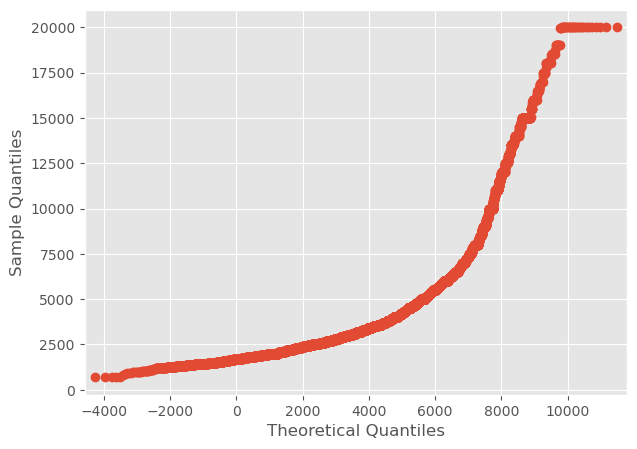

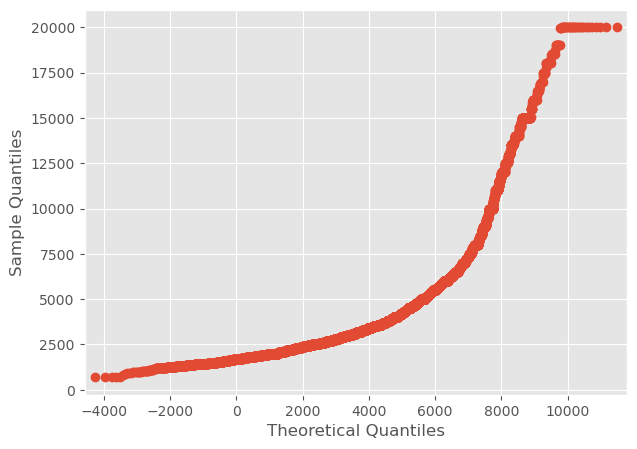

In [24]:
sm.qqplot(price, loc=price.mean(), scale=price.std())

Q-Q графік початкової ознаки.

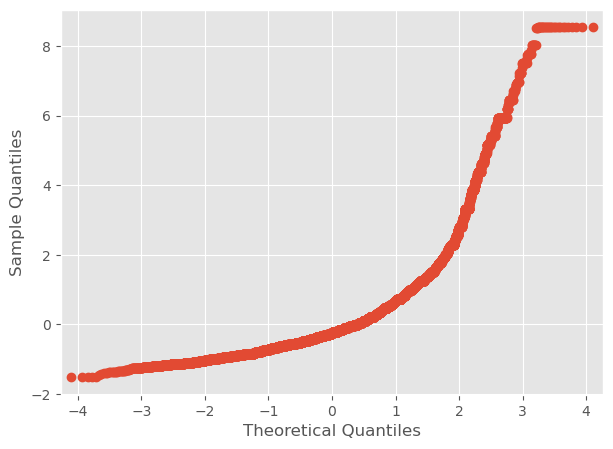

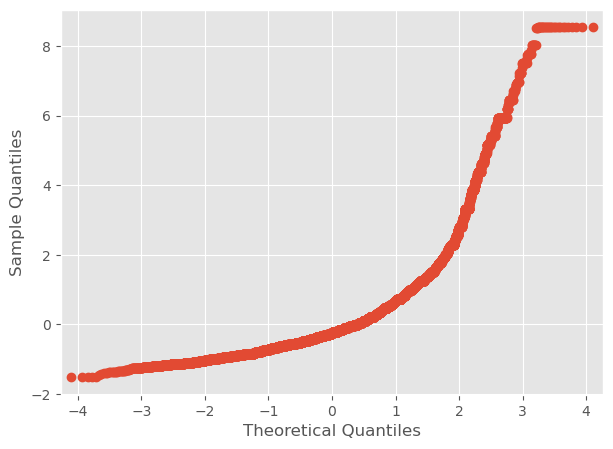

In [25]:
sm.qqplot(price_z, loc=price_z.mean(), scale=price_z.std())

Q-Q графік ознаки після StandardScaler. Форма не змінюється.

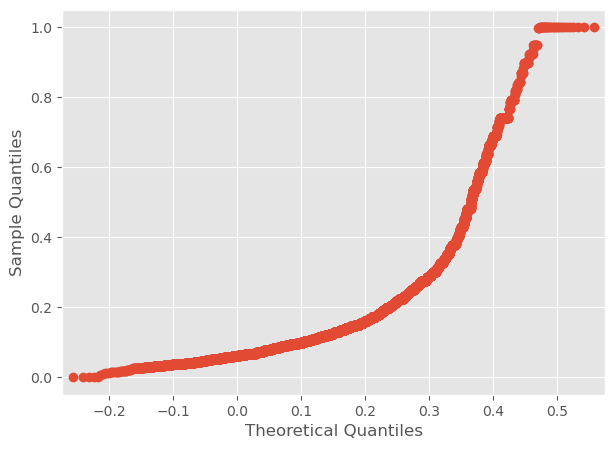

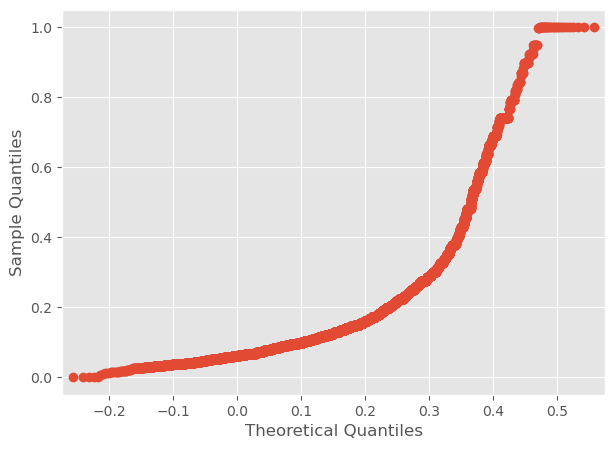

In [26]:
sm.qqplot(price_mm, loc=price_mm.mean(), scale=price_mm.std())

Q-Q графік ознак після MinMaxScaler. Форма не змінюється.

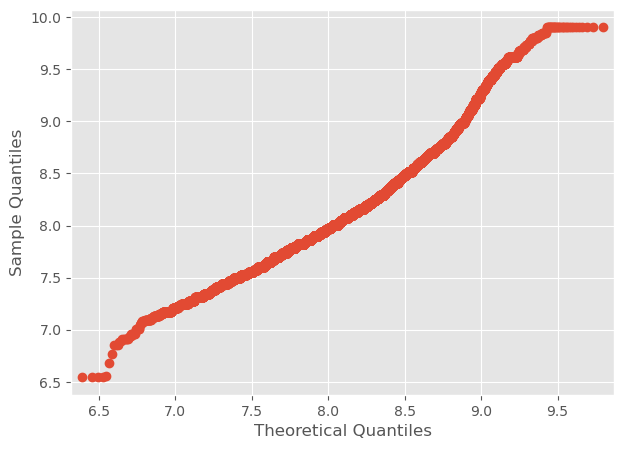

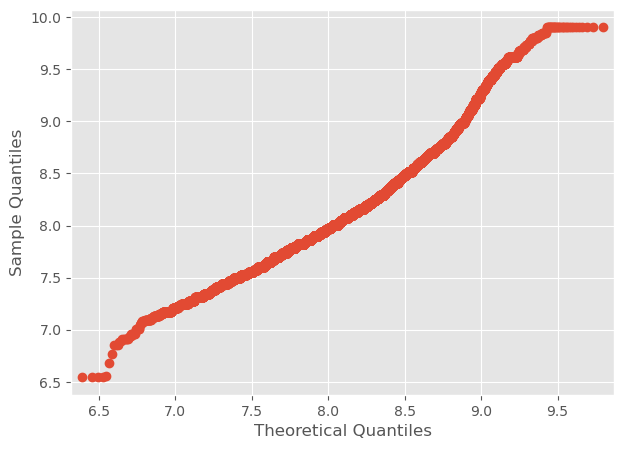

In [27]:
sm.qqplot(price_log, loc=price_log.mean(), scale=price_log.std())

Q-Q графік ознаки після логарифмування. Справи пішли на покращення!

<a class="anchor" id="6.2.2"></a>

### <span style="color:blue; font-size:1.2em;">6.2.2. Взаємодії (Interactions)</span>

[Повернутися до змісту](#6)

Якщо попередні перетворення диктувалися швидше математикою, то цей пункт знову обґрунтований природою даних; його можна віднести як до перетворень, так і до створення нових ознак.

Знову звернемося до задачі [Two Sigma Connect: Rental Listing Inquires](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries). Поміж ознак цієї задачі є кількість кімнат і вартість оренди. Життєва логіка підказує, що вартість у перерахунку на одну кімнату є більш показовою, ніж загальна вартість – отже, можна спробувати виділити таку ознаку.

In [28]:
rooms = df["bedrooms"].apply(lambda x: max(x, .5))

# Уникаємо поділу на нуль; .5 обраний більш-менш довільно
df["price_per_bedroom"] = df["price"] / rooms

Необов'язково керуватися життєвою логікою. Якщо ознак не дуже багато, можна згенерувати всі можливі взаємодії і потім відсіяти зайві, використовуючи одну з технік, що описані в наступному розділі. Крім того, не всі взаємодії між ознаками повинні мати хоч якийсь фізичний зміст: наприклад, [часто використовувані для лінійних моделей](https://d2l.ai/chapter_linear-networks/linear-regression.html) поліноміальні ознаки (див. [sklearn.preprocessing.PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) трактувати практично неможливо.

<a class="anchor" id="6.2.3"></a>

### <span style="color:blue; font-size:1.2em;">6.2.3. Заповнення пропусків</span>

[Повернутися до змісту](#6)

Мало які алгоритми вміють працювати з пропущеними значеннями "з коробки". Водночас реальний світ часто постачає дані з пропусками. На щастя, це одне з тих завдань, для розв'язання яких не потрібна жодна творчість. Обидві ключові для аналізу даних Python бібліотеки надають прості рішення: [pandas.DataFrame.fillna](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) та [sklearn.preprocessing.Imputer](http://scikit-learn.org/stable/modules/preprocessing.html#imputation).

Готові бібліотечні рішення не ховають жодної магії за фасадом. Підходи до оброблення відсутніх значень напрошуються на рівні здорового глузду:

* закодувати окремим порожнім значенням, як `"n/a"` (для категоріальних змінних);
* використати найімовірніше значення ознаки (середнє або медіану для дійсних змінних, найчастіше для категоріальних);
* навпаки, закодувати якимось неймовірним значенням (добре заходить для моделей, що ґрунтуються на деревах рішень, тому що дозволяє зробити поділ на пропущені та непропущені значення);
* для впорядкованих даних (наприклад, часових рядів) можна брати сусіднє значення – наступне чи попереднє.

<img src="https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/6_6_value-error.png" align="center" width=70%>

Зручність використання бібліотечних рішень іноді підказує вставити щось на зразок `df = df.fillna(0)` і не турбуватися за пропуски. Проте це не найрозумніше рішення: більшість часу зазвичай йде не так на побудову моделі, але на підготовку даних. Бездумне неявне заповнення пропусків може заховати баг в обробленні та зіпсувати модель.

<a class="anchor" id="6.3"></a>

## <span style="color:blue; font-size:1.2em;">6.3. Відбір ознак (Feature selection)</span>

[Повернутися до змісту](#6)

Навіщо взагалі проводити відбір ознак? Комусь ця ідея може здатися контрінтуїтивною, але насправді є щонайменше дві важливі причини позбавлятися неважливих ознак. Перша є зрозумілою кожному інженеру: що більше даних, то вищою є обчислювальна складність. Поки ми працюємо з іграшковими наборами даних, розмір даних не є проблемою. Проте для реального навантаженого комерційного проєкту зайві сотні ознак можуть бути вкрай відчутними. Інша причина – деякі алгоритми сприймають шум (неінформативні ознаки) за цільовий сигнал, узагальнюючи надлишкову або непотрібну інформацію.

<a class="anchor" id="6.3.1"></a>

### <span style="color:blue; font-size:1.2em;">6.3.1 Статистичні підходи</span>

[Повернутися до змісту](#6)

Найочевидніший кандидат на вилучення – це ознака, що має незмінне значення, тобто, така, яка не містить жодної інформації. Якщо трохи відійти від цього виродженого випадку, то можна припустити, що низьковаріативні ознаки є дещо гіршими, ніж високоваріативні. Так можна дійти ідеї вилучати ознаки, дисперсія яких нижче певної межі.

In [29]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import make_classification

x_data_generated, y_data_generated = make_classification()
x_data_generated.shape

(100, 20)

In [30]:
VarianceThreshold(.7).fit_transform(x_data_generated).shape

(100, 19)

In [31]:
VarianceThreshold(.8).fit_transform(x_data_generated).shape

(100, 18)

In [32]:
VarianceThreshold(.9).fit_transform(x_data_generated).shape

(100, 14)

Є й інші підходи, що також [ґрунтуються на класичній статистиці](http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection).

In [33]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

x_data_kbest = SelectKBest(f_classif, k=5).fit_transform(x_data_generated, y_data_generated)
x_data_varth = VarianceThreshold(.9).fit_transform(x_data_generated)

In [34]:
cross_val_score(LogisticRegression(), x_data_generated, y_data_generated, scoring='neg_log_loss').mean()

-0.5193481934719989

In [35]:
cross_val_score(LogisticRegression(), x_data_kbest, y_data_generated, scoring='neg_log_loss').mean()

-0.32945239229958423

In [36]:
cross_val_score(LogisticRegression(), x_data_varth, y_data_generated, scoring='neg_log_loss').mean()

-0.5166196198759923

Бачимо, що відібрані ознаки підвищили якість класифікатора. Зрозуміло, що цей приклад є штучним, проте підхід гідний уваги і в реальних завданнях.

<a class="anchor" id="6.3.2"></a>

### <span style="color:blue; font-size:1.2em;">6.3.2. Відбір із використанням моделей</span>

[Повернутися до змісту](#6)

Інший підхід: використовувати певну базову модель для оцінювання ознак. Водночас модель повинна явно демонструвати важливість використаних ознак. Зазвичай використовуються два типи моделей: якийсь "дерев'яний" ансамбль (наприклад, [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)) або лінійна модель з [Lasso регуляризацією](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), яка схильна обнулювати ваги слабких ознак. Логіка інтутивно зрозуміла: якщо ознаки явно марні в простій моделі, то не треба залишати їх і в складній.

In [37]:
# Синтетичний приклад

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

x_data_generated, y_data_generated = make_classification()

pipe = make_pipeline(SelectFromModel(estimator=RandomForestClassifier()), LogisticRegression())

lr = LogisticRegression()
rf = RandomForestClassifier()

print(f"LR + selection: {cross_val_score(lr, x_data_generated, y_data_generated, scoring='neg_log_loss').mean()}")
print(f"LR: {cross_val_score(rf, x_data_generated, y_data_generated, scoring='neg_log_loss').mean()}")
print(f"RF: {cross_val_score(pipe, x_data_generated, y_data_generated, scoring='neg_log_loss').mean()}")

LR + selection: -0.3069808072561334
LR: -0.27234772674425295
RF: -0.22713955125188812


Варто також розуміти, що такий підхід теж не срібна куля – може вийти навіть гірше.

In [38]:
# Повернемося до набору даних Renthop.

#x_data, y_data = get_data() 
x_data = x_data_generated
y_data = y_data_generated

pipe1 = make_pipeline(StandardScaler(), SelectFromModel(estimator=RandomForestClassifier()), LogisticRegression())

pipe2 = make_pipeline(StandardScaler(), LogisticRegression())

rf = RandomForestClassifier()

print(f"LR + selection: {cross_val_score(pipe1, x_data, y_data, scoring='neg_log_loss').mean()}")
print(f"LR: {cross_val_score(pipe2, x_data, y_data, scoring='neg_log_loss').mean()}")
print(f"RF: {cross_val_score(rf, x_data, y_data, scoring='neg_log_loss').mean()}")

LR + selection: -0.233785521147295
LR: -0.31606166204593544
RF: -0.2613436571429124


Стало лише гірше!

<a class="anchor" id="6.3.3"></a>

### <span style="color:blue; font-size:1.2em;"> 6.3.3. Перебір</span>

[Повернутися до змісту](#6)

В решті-решт, найнадійніший, але й найбільш обчислювально складний спосіб ґрунтуються на звичайному переборі:
* навчаємо модель на підмножині "ознак";
* запам'ятовуємо результат;
* повторюємо для різних підмножин;
* порівнюємо якість моделей.

Такий підхід називається [Exhaustive Feature Selection](http://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/).

Перебирати всі комбінації зазвичай занадто довго, так що можна пробувати зменшити простір перебору:
1. Фіксуємо невелике число N.
2. Перебираємо всі комбінації за ознаками N.
3. Вибираємо кращу комбінацію.
4. Далі перебираємо комбінації з N+1 ознак так, що попередня краща комбінація ознак зафіксована, а перебирається тільки нова ознака.

Отже, так можна перебирати, допоки не впораємося в максимально допустиму кількість ознак або поки якість моделі не перестане значно зростати. Цей алгоритм називається [Sequential Feature Selection](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/).

Деталізуємо описаний вище алгоритм: починати з повного простору ознак і викидати ознаки по одній, поки якість моделі залишається сталою або поки не досягнуто бажану кількість ознак.

In [39]:
# Інсталювати mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector

selector = SequentialFeatureSelector(LogisticRegression(), scoring='neg_log_loss', 
                                     verbose=2, k_features=3, forward=False, n_jobs=-1)

selector.fit(x_data, y_data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:    2.5s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:    2.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.7s finished

[2023-12-05 17:10:35] Features: 19/3 -- score: -0.2885863602344868[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.0s finished

[2023-12-05 17:10:35] Features: 18/3 -- score: -0.27416939815560415[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.0s finished

[2023-12-05 17:10:35] Features: 17/3 -- score: -0.2644209223128465[Parallel(n_jobs=-1)]: Using b

SequentialFeatureSelector(estimator=LogisticRegression(), forward=False,
                          k_features=(3, 3), n_jobs=-1, scoring='neg_log_loss',
                          verbose=2)

Можемо переглянути як цей підхід був реалізований в одному простому, але елегантному [ядрі Kaggle](https://www.kaggle.com/arsenyinfo/easy-feature-selection-pipeline-0-55-at-lb).

<a class="anchor" id="6.4"></a>

## <span style="color:blue; font-size:1.2em;">6.4. Основні метрики якості класифікації</span>

[Повернутися до змісту](#6)

<a class="anchor" id="6.4.1"></a>

### <span style="color:blue; font-size:1.2em;">6.4.1. Матриця невідповідностей</span>

[Повернутися до змісту](#6)

Існує багато метрик, що дають змогу обчислити кількісну характеристику бінарного класифікатора. У випадку віднесення одного об'єкта до одного з двох класів можливі 4 результати. Їх зручно відображати за допомогою матриці невідповідностей (з англ. "[confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)"):

- $TP$ – кількість правильно класифікованих цільових об'єктів;
- $FP$ – кількість нецільових об'єктів, що класифіковані як цільові (помилки першого роду);
- $TN$ – кількість правильно класифікованих нецільових прикладів;
- $FN$ – кількість цільових об'єктів, що класифіковані як нецільові (помилки другого роду).

<figure>
<img src="https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/6_8_confusion-matrix.png" alt="Trulli" style="width:100%">
<figcaption align = "center"><i>Джерело: https://encord.com/glossary/confusion-matrix/</i></figcaption>
</figure>

Отримати таку таблицю можна за допомогою функції [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). Необхідно їй на вхід передати дійсні та передбачені класифікатором мітки.

In [40]:
%matplotlib inline
import numpy as np
import seaborn as sns
from sklearn import metrics

true_labels = np.array([0, 1, 0, 0, 1, 1, 1, 1])
predicted_labels = np.array([0, 1, 1, 0, 0, 1, 0, 0])

my_metrics = metrics.confusion_matrix(true_labels, predicted_labels)
print(my_metrics)

[[2 1]
 [3 2]]


<a class="anchor" id="6.4.2"></a>

### <span style="color:blue; font-size:1.2em;">6.4.2. Характеристики бінарного класифікатора</span>

[Повернутися до змісту](#6)

З огляду на таблицю вище, введемо кілька величин, що кількісно характеризують бінарний класифікатор:

$$Recall = TPR = \frac{TP}{TP + FN},$$


$$\quad SPC = \frac{TN}{TN + FP},$$


$$\quad Precision = PPV = \frac{TP}{TP + FP},$$


$$\quad FPR = 1 - SPC,$$


$$ACC = \frac{TP + TN}{TP + TN + FP + FN},$$


$$\quad F1 = 2\frac{PPV\cdot TRP}{PPV + TPR}.$$


Повнота $TPR$ (True positive rate, recall, sensitivity) – частка правильно класифікованих цільових об'єктів поміж усіх цільових об'єктів.

Специфічність $SPC$ (Specificity, true negative rate) – частка правильно класифікованих нецільових об'єктів поміж усіх нецільових об'єктів.

Влучність $PPV$ (Positive predictive value, precision) – частка правильно класифікованих цільових об'єктів поміж усіх об'єктів, що класифіковані праильно.

$FPR$ (False positive rate) – частка помилково класифікованих нецільових об'єктів поміж усіх нецільових об'єктів.

$ACC$ (Accuracy) – частка правильно класифікованих об'єктів поміж усіх об'єктів. $ACC$ є основною характеристикою якості класифікації.

$F1$ (F1-measure) – середнє гармонійне влучності та повноти; ця метрика дає змогу врахувати обидві характеристики одночасно.

In [41]:
PPV = metrics.precision_score(true_labels, predicted_labels)
TPR = metrics.recall_score(true_labels, predicted_labels)
F1 = metrics.f1_score(true_labels, predicted_labels)
ACC = metrics.accuracy_score(true_labels, predicted_labels)
PPV, TPR, F1, ACC

(0.6666666666666666, 0.4, 0.5, 0.5)

<a class="anchor" id="6.4.3"></a>

### <span style="color:blue; font-size:1.2em;">6.4.3. ROC-крива та AUC</span>

[Повернутися до змісту](#6)

Здебільшого бінарні класифікатори мають вигляд $a(x) = \mbox{sign}(f(x, w) - w_0)$, де $w, w_0$ – параметри алгоритму. Тобто спочатку будується розділяюча поверхня $f(x, w) = w_0 $, після чого об'єкти, що перебувають з однієї сторони від неї класифікуються як цільові, з іншої – як нецільові.

ROC-крива (Receiver Operating Characteristic) – це графічна характеристика якості бінарного класифікатора, що виражає залежність TPR від FPR при зміні порога вирішального правила. Ця крива ілюструє, якою буде якість класифікації за різних значень $w_0$ і фіксованому значенні $w$.

ROC-крива проходить через точки (0, 0) та (1, 1) і монотонно не зменшується. Чим ближче крива всередині квадрата $[0, 1]\times[0, 1]$ до лівого верхнього кута, тим краще. Ідеальний варіант – крива, що проходить через три точки: (0, 0), (1, 1) та (0, 1). Діагональ цього квадрата відповідає випадковій класифікації. Типова ROC-крива для класифікатора відповідає кривій на рисунку нижче.

<img src="https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/6_9_ROC.jpg" align="center" width=50%>

На практиці ROC-криву завжди оцінюють за незалежною тестовою вибіркою, щоб уникнути перенавчання.

Площа під ROC-кривою AUC (Area Under Curve) є кількісною характеристикою якості класифікації, яка не залежить від співвідношення помилок. Чим більше значення AUC, тим "краще" є модель класифікації.

<a class="anchor" id="6.4.4"></a>

### <span style="color:blue; font-size:1.2em;">6.4.4. Дисбаланс класів</span>

[Повернутися до змісту](#6)

На практиці у разі дисбалансу класів вдаються до таких [дій](http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/):

- зібрати більше даних, особливо об'єктів рідкісного класу (не завжди можливо);
- використовувати методи, що ґрунтуються на деревах рішень – [випадковий ліс](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) або [градієнтний бустинг над деревами](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html); дерева не так схильні до проблеми дисбалансу класів;
- використовувати метрики типу $F_1$, ROC AUC та [Cohen's kappa](https://en.wikipedia.org/wiki/Cohen%27s_kappa), а не ACC;
- використовувати метрику, в якій помилка на об'єкті з рідкісного класу входить із більшою вагою, ніж помилка на об'єкті з типового класу;
- застосовувати [oversampling](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis) та [undersampling](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis); у першому випадку до вибірки додаються об'єкти рідкісного класу (семплюються із заміщенням), у другому – об'єкти типового класу випадково видаляються з вибірки;
- згенерувати штучні об'єкти рідкісного класу, Synthetic Minority Over-sampling Technique ([SMOTE](https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn)); додаткова [реалізація](https://github.com/fmfn/UnbalancedDataset) на Python;
- розбити один великий клас на кілька менших та застосувати стратегії [One Vs. All](https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/) або [One Vs. One](https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/);
- застосувати алгоритми пошуку викидів або OneClass алгоритми (наприклад, [OneClass SVM](https://machinelearningmastery.com/one-class-classification-algorithms/)).

<a class="anchor" id="6.4.5"></a>

### <span style="color:blue; font-size:1.2em;">6.4.5. Приклади застосувань метрик класифікації</span>

[Повернутися до змісту](#6)

In [42]:
import sys

from sklearn.svm import SVC, LinearSVC

if sys.version_info.major == 2:
    from urllib import urlopen
elif sys.version_info.major == 3:
    from urllib.request import urlopen

from sklearn import datasets
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [43]:
# Завантажуємо дані щодо діабету індіанців Піма зі сховища машинного навчання UCI
pima_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/01_lecture-notes/ida_lecture-06_feature-engineering/diabetes.csv'
data = pd.read_csv(pima_url, delimiter=",")

X = data.iloc[:, :8]
y = data.iloc[:, 8]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Задаємо параметр регуляризації терміну помилки
C = 10.0

# Будуємо класифікатор Suppor Vector Machine
lin_svm = LinearSVC(C=C, dual=False).fit(X_train, y_train)
y_score = lin_svm.decision_function(X_test)

# Обчислюємо ROC-криву та ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

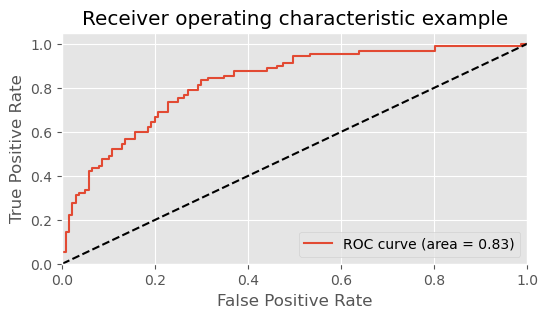

<Figure size 2100x1500 with 0 Axes>

In [44]:
# Будуємо графік ROC-кривої для певного класу
plt.figure(1, figsize=(6,3))
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show(); plt.gcf().set_dpi(300)

Вказані вище характеристики можна використовувати для підбору параметрів алгоритмів, наприклад, за допомогою крос-валідації. Знайдемо оптимальну з погляду $F_1$-міри кількість найближчих сусідів алгоритму $kNN$.

In [45]:
knn = KNeighborsClassifier()
k_s = np.arange(1, 50, 2)

scores_f1 = list()

for k in k_s:
    knn.n_neighbors = k
    scores_f1.append(np.mean(cross_val_score(knn, X, y, scoring="f1")))

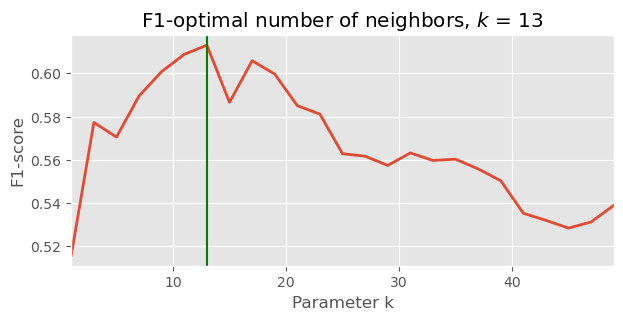

<Figure size 2100x1500 with 0 Axes>

In [46]:
# Будуємо графік
plt.figure(1, figsize=(7,3))
plt.clf(); plt.plot(k_s, scores_f1, linewidth=2)
plt.axvline(k_s[np.argmax(scores_f1)], color="g")
plt.ylabel("F1-score"); plt.xlabel("Parameter k")
plt.xlim(1, 49)
plt.title("F1-optimal number of neighbors, $k$ = %d" % k_s[np.argmax(scores_f1)])
plt.show(); plt.gcf().set_dpi(300)

<a class="anchor" id="6.4.6"></a>

### <span style="color:blue; font-size:1.2em;">6.4.6. Багатокласова класифікація</span>

[Повернутися до змісту](#6)

У разі, коли кількість класів більше двох, матриця невідповідностей визначається аналогічним чином: на перетині $i$-го рядка і $j$-го стовпця стоїть кількість об'єктів $i$-го класу, що відносяться класифікатором до класу $j$.

In [47]:
true_labels = np.array([0, 1, 2, 0, 1, 2, 0, 1, 2])
predicted_labels = np.array([0, 2, 0, 2, 1, 0, 0, 1, 2])

my_metrics2 = metrics.confusion_matrix(true_labels, predicted_labels)
my_metrics2

array([[2, 0, 1],
       [0, 2, 1],
       [2, 0, 1]], dtype=int64)

<a class="anchor" id="6.4.7"></a>

### <span style="color:blue; font-size:1.2em;">6.4.7. One vs. All</span>

[Повернутися до змісту](#6)

Багатокласова класифікація може бути зведена до бінарної у різний спосіб. Одним із них є підхід [One vs. All](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/one-vs-all). Його суть в наступному: для кожного класу $i \in \{1, \dots, k\}$ навчимо бінарний класифікатор $a_i(x) = \mbox{sign}f_i(x)$ на початковій вибірці зі зміненими мітками (об'єкти $i$-го класу отримують мітку 1, всі об'єкти, що залишилися - мітку 0). Іншими словами, ми вчимо $a_i$ відрізняти $i$-ий клас від усіх інших. Після цього підсумковий класифікатор будується як $a(x) = \mbox{argmax}_{i \in \{1, \dots, k\}} f_i(x)$, тобто він видає клас з найбільшою оцінкою $f_i( x) $.

In [48]:
iris = datasets.load_iris()
X, y = iris.data, iris.target

# Масштабування ознак та підлаштування моделі
onevsall = OneVsRestClassifier(make_pipeline(StandardScaler(), LinearSVC(max_iter=10000, C=1.0))).fit(X, y)
accuracy_svc = metrics.accuracy_score(y, onevsall.predict(X))

print(f"Точність класифікації: {accuracy_svc:.7f}")

Точність класифікації: 0.9466667


<a class="anchor" id="6.5"></a>

## <span style="color:blue; font-size:1.2em;">6.5. Корисні посилання</span>

[Повернутися до змісту](#6)

- [Конструювання ознак](https://uk.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BD%D1%81%D1%82%D1%80%D1%83%D1%8E%D0%B2%D0%B0%D0%BD%D0%BD%D1%8F_%D0%BE%D0%B7%D0%BD%D0%B0%D0%BA) [UKR].
- [Feature extraction from scikit-learn](https://scikit-learn.org/stable/modules/feature_extraction.html#) [ENG].
- [Feature importance from scikit-learn](https://scikit-learn.org/stable/modules/permutation_importance.html) [ENG].
- [Feature selection from scikit-learn](https://scikit-learn.org/stable/modules/feature_selection.html) [ENG].
- [Feature selection from scikit-learn. Examples](https://scikit-learn.org/stable/auto_examples/index.html#feature-selection) [ENG].
- [Feature Engineering for Machine Learning](https://www.repath.in/gallery/feature_engineering_for_machine_learning.pdf) *by Alice Zheng & Amanda Casari* [ENG].
- [The Ultimate Guide to 12 Dimensionality Reduction Techniques (with Python codes)](https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/) [ENG].
- [How to improve the accuracy of a classification model?](https://analyticsindiamag.com/how-to-improve-the-accuracy-of-a-classification-model/) [ENG].
- [Матриця невідповідностей](https://uk.wikipedia.org/wiki/%D0%9C%D0%B0%D1%82%D1%80%D0%B8%D1%86%D1%8F_%D0%BD%D0%B5%D0%B2%D1%96%D0%B4%D0%BF%D0%BE%D0%B2%D1%96%D0%B4%D0%BD%D0%BE%D1%81%D1%82%D0%B5%D0%B9) [UKR].
- [ROC-криві. Оглядова стаття](https://dou.ua/forums/topic/33858/) [UKR].
- 8 тактик боротьби з незбалансованими класами у вашому наборі даних машинного навчання на [Machine Learning Mastery](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/) [ENG].